In [1]:
import pandas as pd
import scanpy as sc
import numpy as np
import torch
import sys
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
import sys
sys.path.insert(0, '/home/ph3641/WDM/WDM/')
import clustering
import util_LR
import FRLC_LRDist

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'On device: {device}')
dtype = torch.float64

'''
daniocell_dir = '/scratch/gpfs/ph3641/zebrafish/daniocell.h5ad'
adata_daniocell = sc.read_h5ad(daniocell_dir)
stages = np.unique(adata_daniocell.obs['hpf'].values)
'''

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'On device: {device}')
dtype = torch.float64

filehandle_zf = '/scratch/gpfs/ph3641/zebrafish/'

zf_list = ['zf3', 'zf5', 'zf10', 'zf12', 'zf18', 'zf24']
zf_names = zf_list
filehandles_zf = [filehandle_zf + 'pair' + str(k) + '/' for k in range(len(zf_list))]
N = len(filehandles_zf)

spatial_list = []
exclude_rows = [1099, None, None, 325, None, None]

for i in range(len(zf_list)):
    file_spatial = filehandles_zf[i] + zf_names[i] +'_spatial.npy'
    if i == len(zf_list) - 1:
        file_spatial = filehandles_zf[i-1] + zf_names[i] +'_spatial.npy'
    spatial = np.load(file_spatial)
    nidx = exclude_rows[i]
    if nidx is not None:
        spatial = np.concatenate((spatial[:nidx,:], spatial[nidx+1:,:]))
    spatial_list.append(spatial)


def load_mats(save_dir, s1_name, s2_name, device, z=None, c=100, nidx_1=None, nidx_2=None):
    # Load costs
    A = np.load(save_dir + 'SA.npy')
    B = np.load(save_dir + 'SB.npy')
    
    ys = torch.from_numpy(np.load(save_dir + s1_name + f'_feature.npy')).type(torch.DoubleTensor).to(device)
    ys2 = torch.from_numpy(np.load(save_dir + s2_name + f'_feature.npy')).type(torch.DoubleTensor).to(device)
    
    if nidx_1 is not None:
        ys = torch.cat((ys[:nidx_1,:], ys[nidx_1+1:,:]))
    if nidx_2 is not None:
        ys2 = torch.cat((ys2[:nidx_2,:], ys2[nidx_2+1:,:]))
    
    C = torch.cdist(ys, ys2).type(torch.DoubleTensor).to(device)
    
    norm1 = c
    norm2 = A.max()*c
    norm3 = B.max()*c
    
    if z is None:
        # No low-rank factorization applied to the distance matrix
        A = torch.from_numpy(A).to(device)
        B = torch.from_numpy(B).to(device)
        C_factors = (C/ (norm1), torch.eye(C.shape[1]).type(torch.DoubleTensor).to(device))
        A_factors = (A/ (norm2), torch.eye(A.shape[1]).type(torch.DoubleTensor).to(device))
        B_factors = (B/ (norm3), torch.eye(B.shape[1]).type(torch.DoubleTensor).to(device))

    else:
        # Distance matrix factored using SVD
        u, s, v = torch.svd(C)
        print('C done')
        V_C,U_C = torch.mm(u[:,:z], torch.diag(s[:z])), v[:,:z].mT
        u, s, v = torch.svd(torch.from_numpy(A).to(device))
        print('A done')
        V1_A,V1_B = torch.mm(u[:,:z], torch.diag(s[:z])), v[:,:z].mT
        u, s, v = torch.svd(torch.from_numpy(B).to(device))
        print('B done')
        V2_A,V2_B = torch.mm(u[:,:z], torch.diag(s[:z])), v[:,:z].mT
        C_factors, A_factors, B_factors = ((V_C.type(torch.DoubleTensor).to(device)/norm1, U_C.type(torch.DoubleTensor).to(device)/norm1), \
                                       (V1_A.type(torch.DoubleTensor).to(device)/norm2, V1_B.type(torch.DoubleTensor).to(device)/norm2), \
                                       (V2_A.type(torch.DoubleTensor).to(device)/norm3, V2_B.type(torch.DoubleTensor).to(device)/norm3))
    
    return C_factors, A_factors, B_factors


On device: cuda
On device: cuda


In [2]:

N = len(filehandles_zf)
Qs = [None]*(N-1)
Rs = [None]*(N-1)

key = 'bin_annotation'

labels = []

for i in range(N-2, -1, -1):

    s1_name = zf_names[i]
    s2_name = zf_names[i+1]
    
    print(f'Slice pair {i}, aligning {s1_name} to {s2_name}')
    
    adata_pair = sc.read_h5ad(filehandle_zf + f'pair{i}/' + s1_name + '_' + s2_name + '.h5ad')
    
    adata1 = adata_pair[adata_pair.obs['timepoint'] == 1]
    sc.pp.normalize_total(adata1)
    sc.pp.log1p(adata1)
    
    adata2 = adata_pair[adata_pair.obs['timepoint'] == 2]
    sc.pp.normalize_total(adata2)
    sc.pp.log1p(adata2)
    
    encoder1 = OneHotEncoder(sparse_output=False)
    ys_onehot1 = encoder1.fit_transform(adata1.obs[key].values.reshape(-1, 1))
    _Q = ys_onehot1 / np.sum(ys_onehot1)
    
    encoder2 = OneHotEncoder(sparse_output=False)
    ys_onehot2 = encoder2.fit_transform(adata2.obs[key].values.reshape(-1, 1))
    _R = ys_onehot2 / np.sum(ys_onehot2)

    labels.append(list(encoder2.categories_[0]))
    
    if i == 0:
        labels.append(list(encoder1.categories_[0]))
    
    _Q, _R = torch.from_numpy(_Q).to(device).float(), torch.from_numpy(_R).to(device).float()

    # Filter rows
    nidx_1, nidx_2 = exclude_rows[i], exclude_rows[i+1]
    if nidx_1 is not None:
        _Q = torch.cat((_Q[:nidx_1,:], _Q[nidx_1+1:,:]))
    if nidx_2 is not None:
        _R = torch.cat((_R[:nidx_2,:], _R[nidx_2+1:,:]))
        
    Qs[i], Rs[i] = _Q, _R

labels.reverse()

Slice pair 4, aligning zf18 to zf24


/home/ph3641/.conda/envs/peterenv2/lib/python3.12/site-packages/scanpy/preprocessing/_normalization.py:206: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)
/home/ph3641/.conda/envs/peterenv2/lib/python3.12/site-packages/scanpy/preprocessing/_normalization.py:206: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


Slice pair 3, aligning zf12 to zf18


/home/ph3641/.conda/envs/peterenv2/lib/python3.12/site-packages/scanpy/preprocessing/_normalization.py:206: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)
/home/ph3641/.conda/envs/peterenv2/lib/python3.12/site-packages/scanpy/preprocessing/_normalization.py:206: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


Slice pair 2, aligning zf10 to zf12
Slice pair 1, aligning zf5 to zf10


/home/ph3641/.conda/envs/peterenv2/lib/python3.12/site-packages/scanpy/preprocessing/_normalization.py:206: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)
/home/ph3641/.conda/envs/peterenv2/lib/python3.12/site-packages/scanpy/preprocessing/_normalization.py:206: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)
/home/ph3641/.conda/envs/peterenv2/lib/python3.12/site-packages/scanpy/preprocessing/_normalization.py:206: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)
/home/ph3641/.conda/envs/peterenv2/lib/python3.12/site-packages/scanpy/preprocessing/_normalization.py:206: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


Slice pair 0, aligning zf3 to zf5


/home/ph3641/.conda/envs/peterenv2/lib/python3.12/site-packages/scanpy/preprocessing/_normalization.py:206: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)
/home/ph3641/.conda/envs/peterenv2/lib/python3.12/site-packages/scanpy/preprocessing/_normalization.py:206: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


In [3]:

spatial_list2 = []
for i in range(len(zf_list)):
    file_spatial = filehandles_zf[i] + zf_names[i] +'_spatial.npy'
    if i == len(zf_list) - 1:
        file_spatial = filehandles_zf[i-1] + zf_names[i] +'_spatial.npy'
    spatial = np.load(file_spatial)
    spatial_list2.append(spatial)

In [4]:
import matplotlib.pyplot as plt

def plot_side_by_side_bars(data1, data2, xtick_labels, title):
    N = data1.shape[0]
    # Define the positions of the bars
    ind = np.arange(N)
    width = 0.35
    # Create the bar plot
    fig, ax = plt.subplots(figsize=(10, 6), dpi=150)
    bars1 = ax.bar(ind - width/2, data1, width, label='Unsupervised clusters', color='skyblue', edgecolor='black')
    bars2 = ax.bar(ind + width/2, data2, width, label='Annotated clusters', color='salmon', edgecolor='black')
    
    # Add labels, title, and legend
    ax.set_xlabel('Timepoint pair', fontsize=14)
    ax.set_ylabel('Optimal cost value', fontsize=14)
    ax.set_title(title, fontsize=16, fontweight='bold')
    ax.set_xticks(ind)
    ax.set_xticklabels(xtick_labels, fontsize=12)
    ax.legend(fontsize=12)

    # Add gridlines for better readability
    ax.grid(True, which='both', linestyle='--', linewidth=0.5)
    
    # Show the plot
    plt.tight_layout()
    plt.show()


In [5]:
Qs.append(Rs[-1])
rank_list = [(3,7),(7,7),(7,11),(11,14),(14,19)]
exclude_rows = [1099, None, None, 325, None, None]

In [6]:
import WassersteinDiffMap
import FRLC_LRDist
import importlib

importlib.reload(WassersteinDiffMap)

i = 2

s1_name = zf_names[i]
s2_name = zf_names[i+1]
s3_name = zf_names[i+2]
print(f'Aligning slices {s1_name} to {s2_name} to {s3_name}')

r1, r2 = rank_list[i]
r2, r3 = rank_list[i+1]
nidx_1, nidx_2, nidx_3 = exclude_rows[i], exclude_rows[i+1], exclude_rows[i+2]

filehandle_pair = filehandle_zf + 'pair' + str(i) + '/'
save_dir = filehandle_pair
C_factors12, A_factors11, A_factors22 = load_mats(save_dir, s1_name, s2_name, \
                                                device, z=400, c=100, nidx_1=nidx_1, nidx_2=nidx_2)

filehandle_pair = filehandle_zf + 'pair' + str(i+1) + '/'
save_dir = filehandle_pair
C_factors23, A_factors22, A_factors33 = load_mats(save_dir, s2_name, s3_name, \
                                                device, z=400, c=100, nidx_1=nidx_2, nidx_2=nidx_3)

c = max(torch.max(C_factors12[0] @ C_factors12[1]), torch.max( C_factors23[0] @ C_factors23[1]))
c = max(c, 1/c)

C_factors12 = (C_factors12[0]/c, C_factors12[1]/c)
C_factors23 = (C_factors23[0]/c, C_factors23[1]/c)

C_factors_sequence, A_factors_sequence = (C_factors12, C_factors23), (A_factors11, A_factors22, A_factors33)

ranks = [rank_list[i], rank_list[i+1]]

# Initialize as arguments
init_args = (Qs[i].type(torch.DoubleTensor).to(device), Qs[i+2].type(torch.DoubleTensor).to(device))
Q0, Q2 = init_args


Aligning slices zf10 to zf12 to zf18
C done
A done
B done
C done
A done
B done


In [24]:
'''
gamma=30
tau_out=1
tau_in=1e-7
alpha = 0.008
beta = 0.0'''

gamma=30
tau_out=1
tau_in=1e-7
alpha = 0.009
beta = 0.0

# Learn smoothed co-clustering Q_t; partially annotated with label-transfer
Q1, T_tm1t, T_ttp1 = FRLC_LRDist.FRLC_LR_opt_multimarginal(C_factors12, \
                                              A_factors11, \
                                             A_factors22, \
                                                C_factors23, \
                                              A_factors22, \
                                             A_factors33,  \
                                            r=r2, max_iter=120, device=device, \
                                             returnFull=False, alpha=alpha, beta=beta, \
                                            min_iter = 100, initialization='Full', tau_out=tau_out, tau_in=tau_in, gamma=gamma, \
                                            dtype=torch.float64, init_args=init_args)

print(torch.sum(Q1, axis=0))

Ranks: r1 7, r2 11, r3 14
Iteration: 0
Iteration: 25
Iteration: 50
Iteration: 75
tensor([0.0813, 0.0744, 0.1093, 0.0821, 0.1162, 0.0684, 0.1487, 0.0761, 0.0908,
        0.0655, 0.0867], device='cuda:0', dtype=torch.float64)


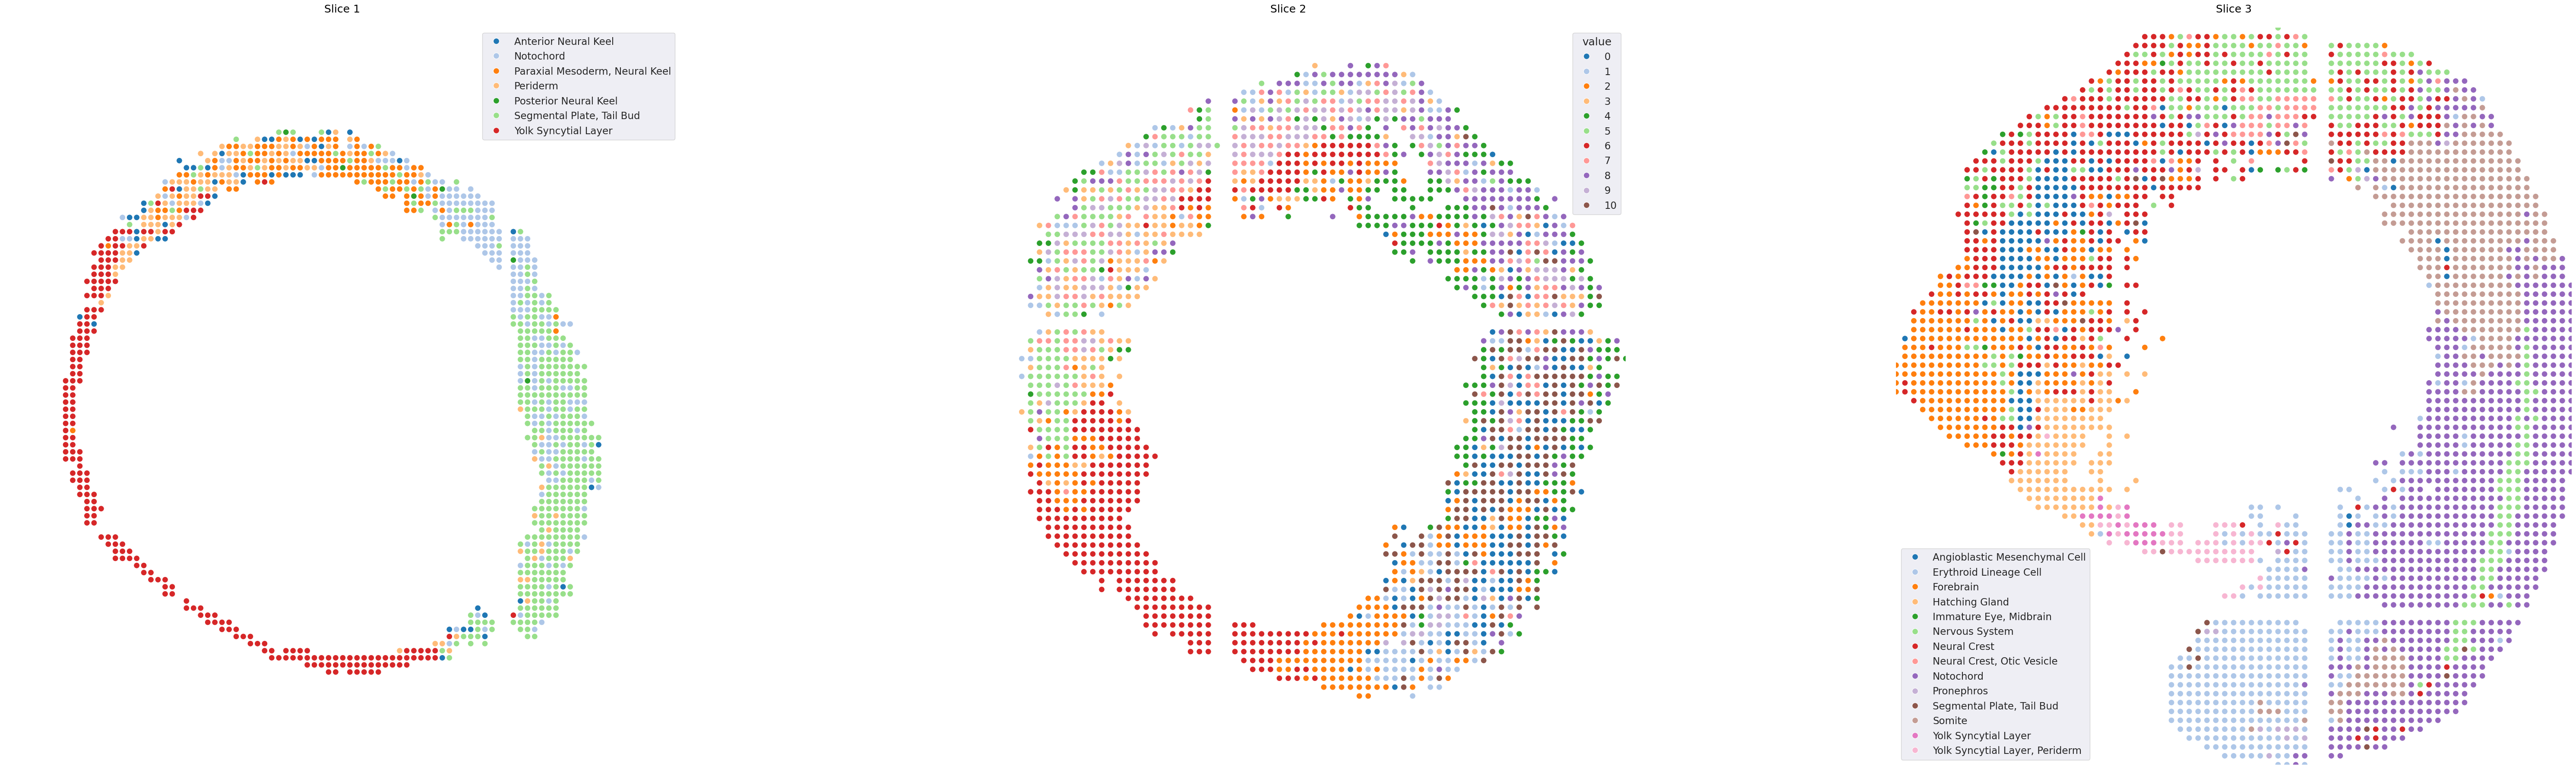

3 7 11
3 7 11
3 7 11
3 7 11
3 7 11
3 7 11
3 7 11
3 7 11
3 7 11
3 7 11
3 7 11
3 7 11
3 7 11
3 7 11
3 7 11
3 7 11
3 7 11
3 7 11
3 7 11
3 7 11
3 7 11
3 7 11
3 7 11
3 7 11
3 7 11
3 7 11
3 7 11
3 7 11
3 7 11
3 7 11
3 7 11
3 7 11
3 7 11
3 7 11
3 7 11
3 7 11
3 7 11
3 7 11
3 7 11
3 7 11
3 7 11
3 7 11
3 7 11
3 7 11
3 7 11
3 7 11
3 7 11
3 7 11
3 7 11
3 7 11
3 7 11
3 7 11
3 7 11
3 7 11
3 7 11
3 7 11
3 7 11
3 7 11
3 7 11
3 7 11
3 7 11
3 7 11
3 7 11
3 7 11
3 7 11
3 7 11
3 7 11
3 7 11
3 7 11
3 7 11
3 7 11
3 7 11
3 7 11
3 11 14
3 11 14
3 11 14
3 11 14
3 11 14
3 11 14
3 11 14
3 11 14
3 11 14
3 11 14
3 11 14
3 11 14
3 11 14
3 11 14
3 11 14
3 11 14
3 11 14
3 11 14
3 11 14
3 11 14
3 11 14
3 11 14
3 11 14
3 11 14
3 11 14
3 11 14
3 11 14
3 11 14
3 11 14
3 11 14
3 11 14
3 11 14
3 11 14
3 11 14
3 11 14
3 11 14
3 11 14
3 11 14
3 11 14
3 11 14
3 11 14
3 11 14
3 11 14
3 11 14
3 11 14
3 11 14
3 11 14
3 11 14
3 11 14
3 11 14
3 11 14
3 11 14
3 11 14
3 11 14
3 11 14
3 11 14
3 11 14
3 11 14
3 11 14
3 11 14
3 11 14
3

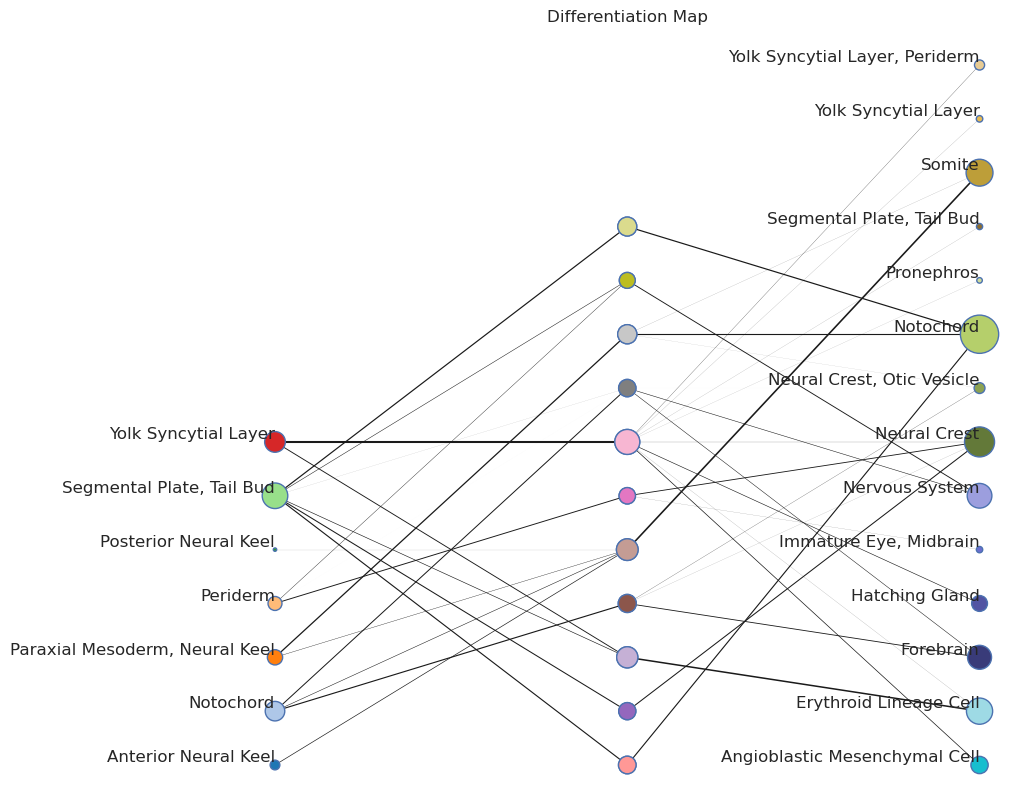

In [25]:
xs0 = torch.from_numpy(spatial_list[i]).to(device)
xs = torch.from_numpy(spatial_list[i+1]).to(device)
xs2 = torch.from_numpy(spatial_list[i+2]).to(device)

Ss = [xs0.cpu().numpy(), xs.cpu().numpy(), xs2.cpu().numpy()]
Qs_ann = [Q0.cpu().numpy(), Q1.cpu().numpy(), Q2.cpu().numpy()]
Ts_ann = [T_tm1t.cpu().numpy(), T_ttp1.cpu().numpy() ]
#node_labels = None 

ct_ann_0 = labels[i]
ct_ann_1 = labels[i+1]
ct_ann_2 = labels[i+2]

node_labels1 = [ct_ann_0, None, ct_ann_2]

clustering.plot_clusters_from_QT(Ss, Qs_ann, Ts_ann, node_labels1)
clustering.diffmap_from_QT(Qs_ann, Ts_ann, node_labels=node_labels1)

#clustering.plot_clusters_from_QT(Ss, Qs_ann, Ts_ann, node_labels, clustering_type='ancestral')

In [26]:
import seaborn as sns

def plot_cluster_transfer(S1, S2, labels_W, labels_H, dotsize=15, \
                      spacing=20, flipy=True, color_scheme='tab', \
                      title=None, save_name=None, flip=False, cell_type_labels=None):
    """
    Input
        S1 : np.ndarray, spatial coordinates for the first slice of shape (n, 2)
        S2 : np.ndarray, spatial coordinates for the second slice of shape (m, 2)
        Q : np.ndarray, first FRLC subcoupling of shape (n, r) 
        R : np.ndarray, second FRLC subcoupling of shape (m, r)
        T : np.ndarray, latent coupling of shape (r, r)
        num_clusters : int, number of clusters, default=30, we use minimum of this input and rank r
        color_scheme : str, color scheme for the clusters, default='tab', other options: 'rainbow'
        title : str, title for the plot, default=None
        save_name : str, file name to save the plot, default=None
        flip : bool, whether to flip the spatial coordinates, default=False

    Output
        Plots the two slices side by side with spots colored according to their labels from k-means clustering
    """
    set_labels_W = set(labels_W)
    set_labels_H = set(labels_H)
    labels_union = set_labels_W.union(set_labels_H)
    labels_intersection = set_labels_W.intersection(set_labels_H)
    print(f'Number of clusters in slice 1: {len(set_labels_W)}')
    print(f'Number of clusters in slice 2: {len(set_labels_H)}')
    print(f'Number of clusters in common: {len(labels_intersection)}')
    print(f'Number of clusters total: {len(labels_union)}')
    
    num_clusters = len(labels_union)
    sns.set_style("darkgrid")
    sns.set_context("notebook", font_scale=1.5)
    fig, axes = plt.subplots(1, 2, figsize=(32, 20), facecolor='white')

    S1 = S1.cpu().numpy()
    S2 = S2.cpu().numpy()

    S1 = S1 - np.mean(S1, axis=0)
    S2 = S2 - np.mean(S2, axis=0)
    
    slices = [S1, S2]
    labels = [labels_W, labels_H]
    unique_values = np.unique(np.concatenate(labels))
        
    if color_scheme == 'tab':
        cmap_tab20 = plt.get_cmap('tab20')
        cmap_tab20b = plt.get_cmap('tab20b')

        colors_tab20 = [cmap_tab20(i) for i in range(cmap_tab20.N)]
        colors_tab20b = [cmap_tab20b(i) for i in range(cmap_tab20b.N)]

        combined_colors = colors_tab20 + colors_tab20b
        colors = [combined_colors[i % len(combined_colors)] for i in range(len(unique_values))]
    else: 
        colors = [mcolors.hsv_to_rgb((i / num_clusters, 1, 1)) for i in range(num_clusters)]
    
    # Make color_dict for either color scheme
    color_dict = dict(zip(unique_values, colors))
   
    xmin = np.min([np.min(S1[:, 0]), np.min(S2[:, 0])])
    xmax = np.max([np.max(S1[:, 0]), np.max(S2[:, 0])])
    ymin = np.min([np.min(S1[:, 1]), np.min(S2[:, 1])])
    ymax = np.max([np.max(S1[:, 1]), np.max(S2[:, 1])])
    
    for i, (S, value_vec) in enumerate(zip(slices, labels)):
        ax = axes[i]
        ax.set_facecolor('black')

        spatial = S if not flip else S @ np.array([[-1, 0], [0, 1]])
        df = pd.DataFrame({'x': spatial[:, 0], 'y': spatial[:, 1], 'value': value_vec})

        sns.scatterplot(
            x='x', y='y', hue='value', palette=color_dict, data=df, ax=ax, s=dotsize, legend=True
        )

        ax.set_xlim(xmin - spacing, xmax + spacing)
        ax.set_ylim(ymin - spacing, ymax + spacing)
        if flipy:
            ax.invert_yaxis()
        else:
            pass
        ax.axis('off')
        ax.set_title(f'Slice {i+1}\n', color='black')
        ax.set_aspect('equal', adjustable='box')

        if cell_type_labels is not None and i == 0:
            unique_values_2 = np.unique(np.array(labels_W))
            cell_type_labels_2 = [cell_type_labels[i] for i in unique_values_2]
            handles, labels = ax.get_legend_handles_labels()
            ax.legend(handles=handles, labels=cell_type_labels_2, title='')
        elif cell_type_labels is not None and i == 1:
            cell_type_labels_3 = [cell_type_labels[i] for i in unique_values]
            handles, labels = ax.get_legend_handles_labels()
            ax.legend(handles=handles, labels=cell_type_labels_3, title='')
            
    plt.tight_layout()
    #plt.legend()
    
    if title:
        plt.suptitle(title, fontsize=16, color='black')

    if save_name:
        plt.savefig(save_name, dpi=300, transparent=True, bbox_inches="tight", facecolor='black')

    plt.show()
    
    if cell_type_labels is not None:
        cell_type_labelsA = []
        for label_idx in labels_W:
            cell_type_labelsA.append(cell_type_labels[label_idx])
        cell_type_labelsB = []
        for label_idx in labels_H:
            cell_type_labelsB.append(cell_type_labels[label_idx])
        return cell_type_labelsA, cell_type_labelsB
    else:
        return

/tmp/ipykernel_2627051/2742232172.py:3: ImplicitModificationWarning: Setting element `.obsm['spatial']` of view, initializing view as actual.
  adata1.obsm['spatial'] = adata1.obs[['spatial_x', 'spatial_y']].to_numpy()


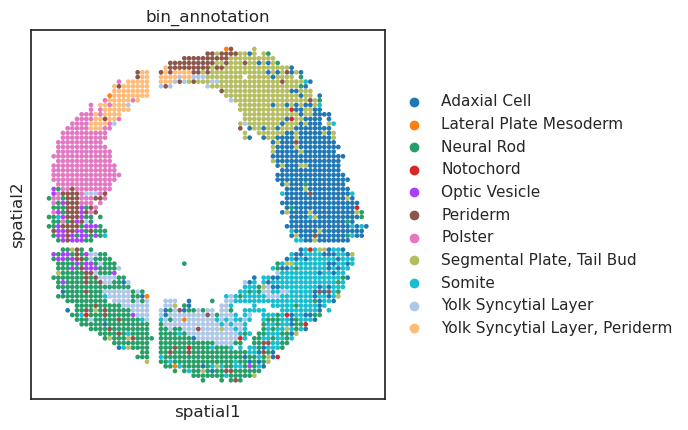

/tmp/ipykernel_2627051/2742232172.py:6: ImplicitModificationWarning: Setting element `.obsm['spatial']` of view, initializing view as actual.
  adata2.obsm['spatial'] = adata2.obs[['spatial_x', 'spatial_y']].to_numpy()


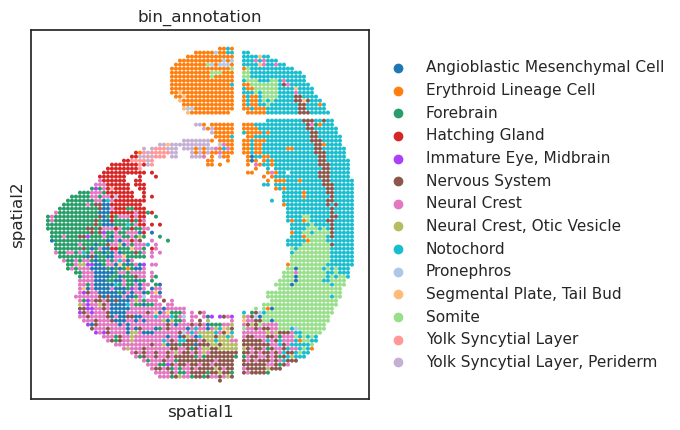

Progress: 0/3048
['Angioblastic Mesenchymal Cell', 'Erythroid Lineage Cell', 'Forebrain', 'Hatching Gland', 'Immature Eye, Midbrain', 'Nervous System', 'Neural Crest', 'Neural Crest, Otic Vesicle', 'Notochord', 'Pronephros', 'Segmental Plate, Tail Bud', 'Somite', 'Yolk Syncytial Layer', 'Yolk Syncytial Layer, Periderm']
Number of clusters in slice 1: 11
Number of clusters in slice 2: 8
Number of clusters in common: 8
Number of clusters total: 11


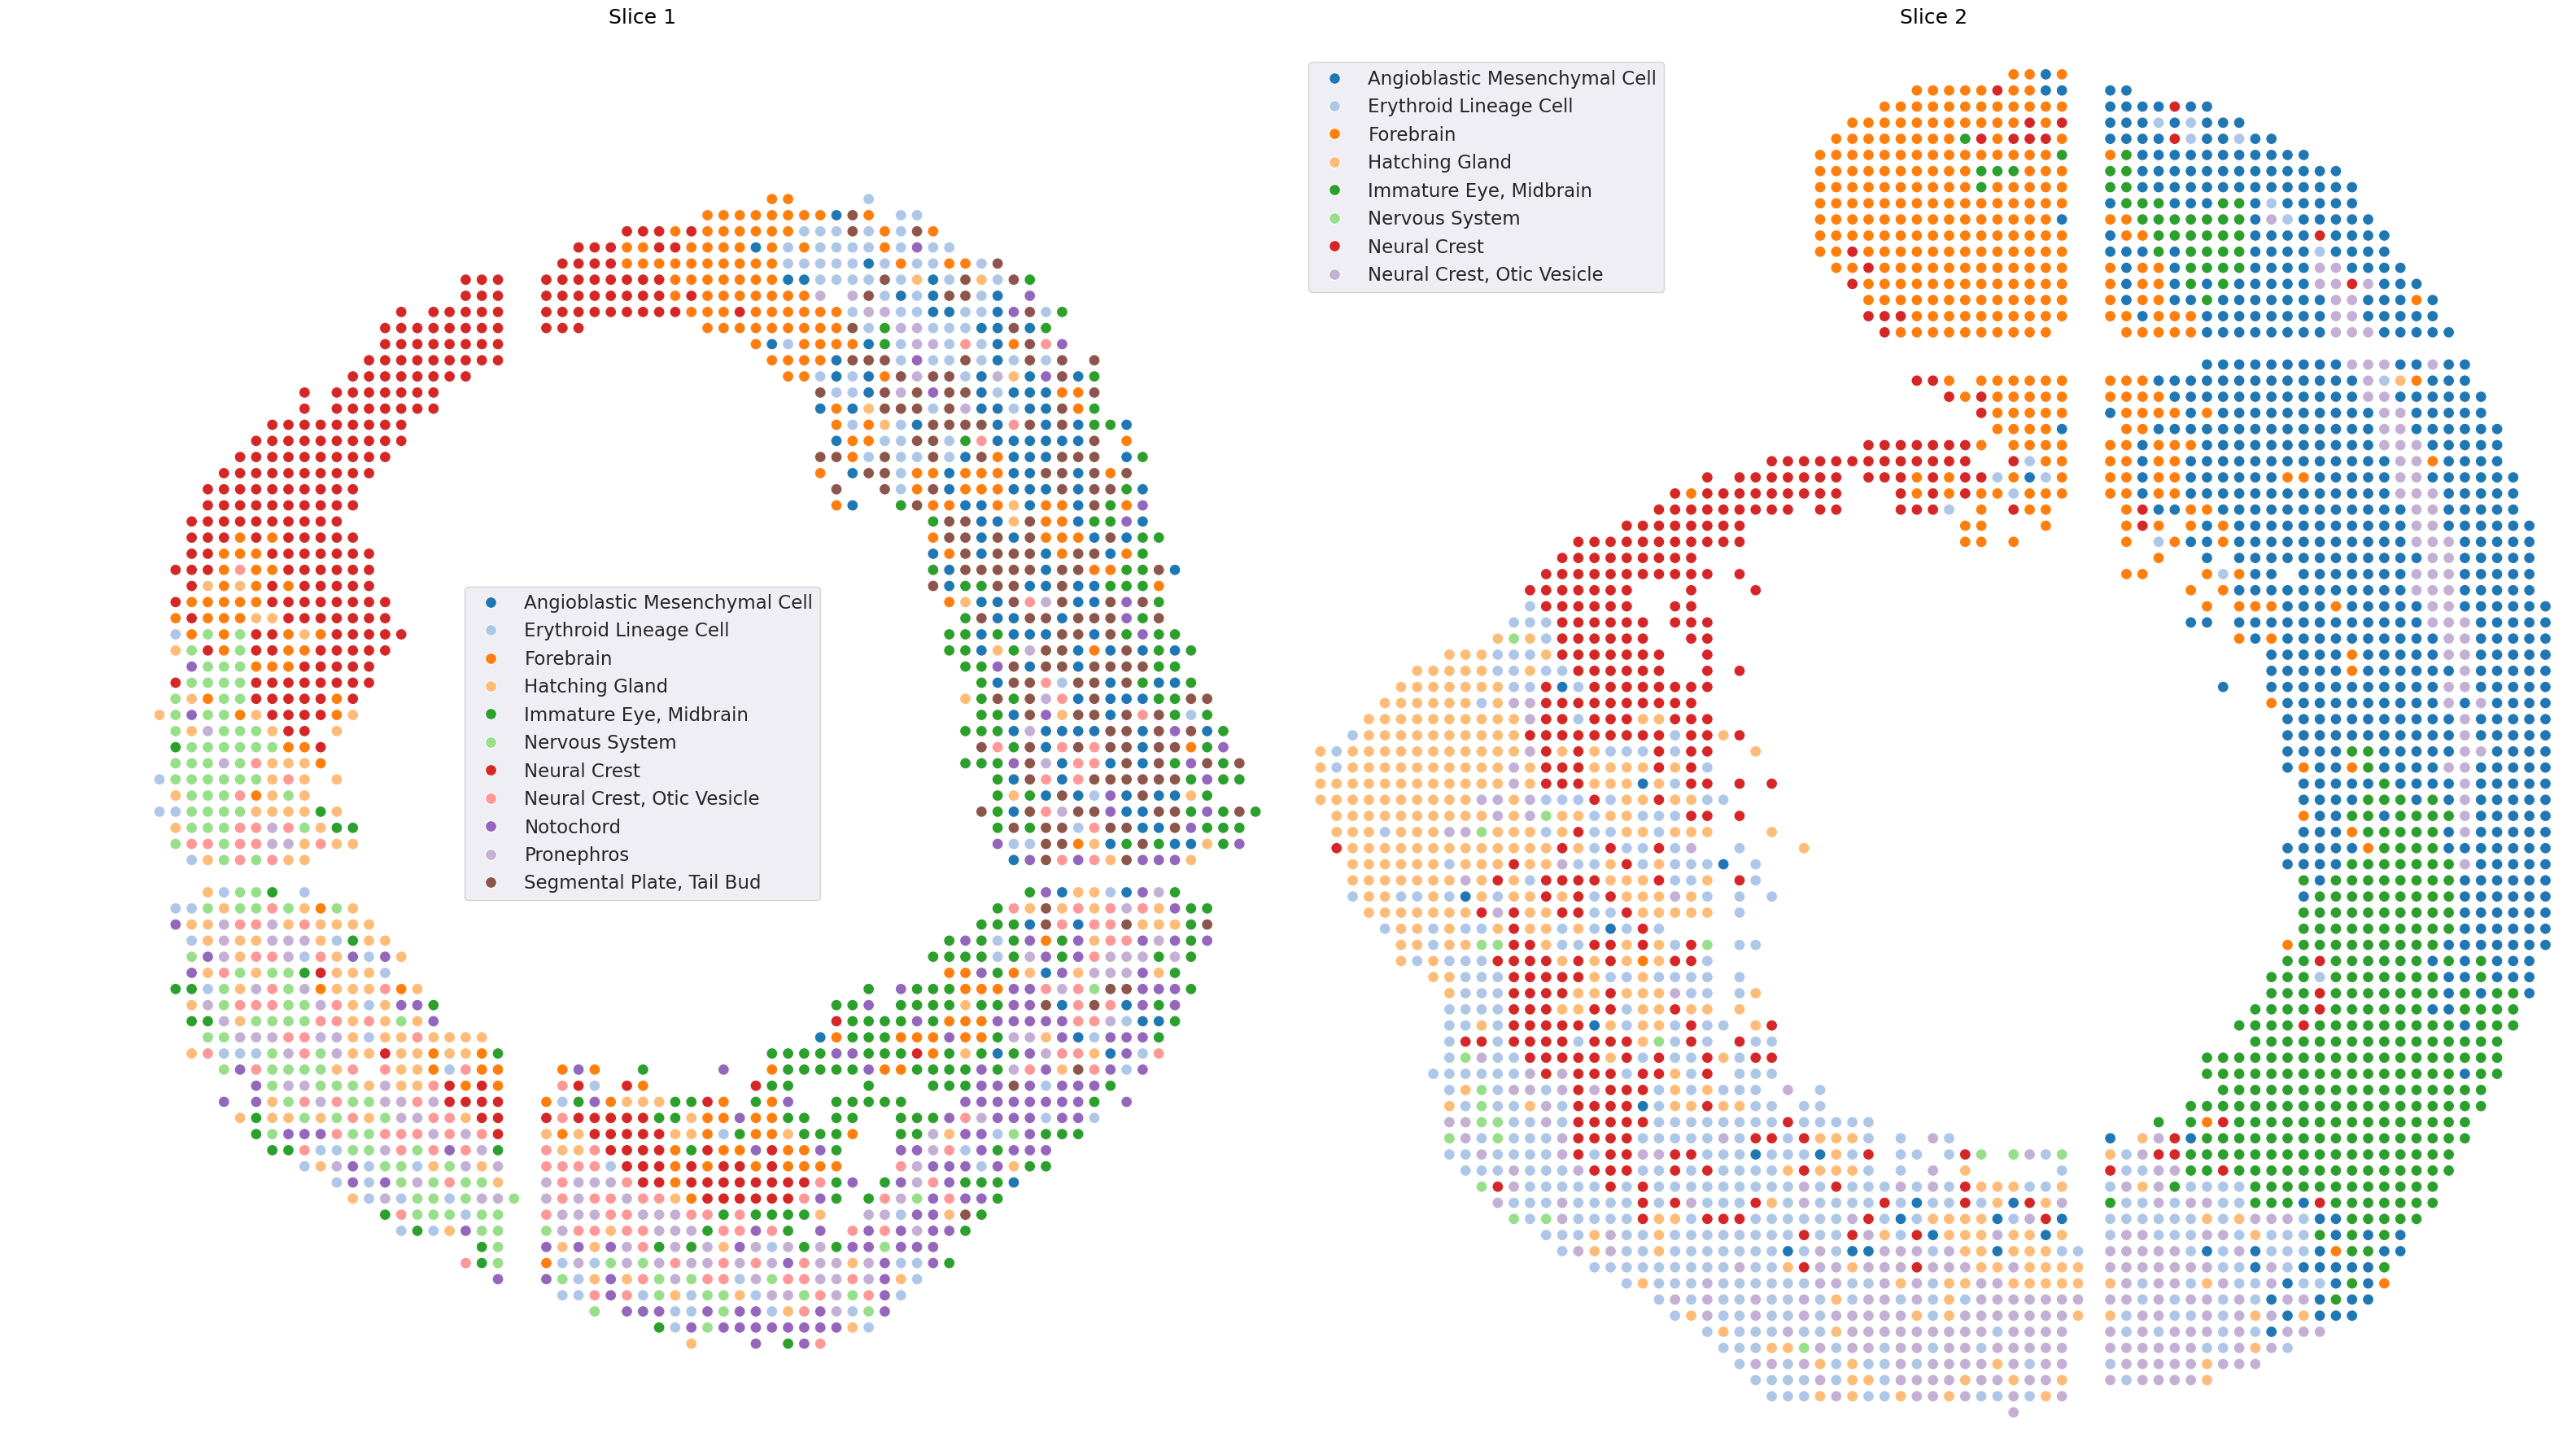

In [27]:
adata_pair = sc.read_h5ad(save_dir + s2_name + '_' + s3_name + '.h5ad')
adata1 = adata_pair[adata_pair.obs['timepoint'] == 1]
adata1.obsm['spatial'] = adata1.obs[['spatial_x', 'spatial_y']].to_numpy()
sc.pl.spatial(adata1, color = ["bin_annotation"], spot_size=15, na_color="white")
adata2 = adata_pair[adata_pair.obs['timepoint'] == 2]
adata2.obsm['spatial'] = adata2.obs[['spatial_x', 'spatial_y']].to_numpy()
sc.pl.spatial(adata2, color = ["bin_annotation"], spot_size=15, na_color="white")

#ml_labels_W, ml_labels_H = clustering.max_likelihood_clustering(Q1.cpu().numpy(), Q2.cpu().numpy())
ml_labels_W, ml_labels_H = clustering.ancestral_clustering(Q1.cpu().numpy(),Q2.cpu().numpy(),T_ttp1.cpu().numpy(), full_P=False)

cell_type_labels = labels[i+2]
print(cell_type_labels)
cell_type_labelsA, cell_type_labelsB = plot_cluster_transfer(xs, xs2,
                                 ml_labels_W,
                                 ml_labels_H,
                                 dotsize=100,
                                 cell_type_labels=cell_type_labels)

3 7 11
3 7 11
3 7 11
3 7 11
3 7 11
3 7 11
3 7 11
3 7 11
3 7 11
3 7 11
3 7 11
3 7 11
3 7 11
3 7 11
3 7 11
3 7 11
3 7 11
3 7 11
3 7 11
3 7 11
3 7 11
3 7 11
3 7 11
3 7 11
3 7 11
3 7 11
3 7 11
3 7 11
3 7 11
3 7 11
3 7 11
3 7 11
3 7 11
3 7 11
3 7 11
3 7 11
3 7 11
3 7 11
3 7 11
3 7 11
3 7 11
3 7 11
3 7 11
3 7 11
3 7 11
3 7 11
3 7 11
3 7 11
3 7 11
3 7 11
3 7 11
3 7 11
3 7 11
3 7 11
3 7 11
3 7 11
3 7 11
3 7 11
3 7 11
3 7 11
3 7 11
3 7 11
3 7 11
3 7 11
3 7 11
3 7 11
3 7 11
3 7 11
3 7 11
3 7 11
3 7 11
3 7 11
3 7 11
3 11 14
3 11 14
3 11 14
3 11 14
3 11 14
3 11 14
3 11 14
3 11 14
3 11 14
3 11 14
3 11 14
3 11 14
3 11 14
3 11 14
3 11 14
3 11 14
3 11 14
3 11 14
3 11 14
3 11 14
3 11 14
3 11 14
3 11 14
3 11 14
3 11 14
3 11 14
3 11 14
3 11 14
3 11 14
3 11 14
3 11 14
3 11 14
3 11 14
3 11 14
3 11 14
3 11 14
3 11 14
3 11 14
3 11 14
3 11 14
3 11 14
3 11 14
3 11 14
3 11 14
3 11 14
3 11 14
3 11 14
3 11 14
3 11 14
3 11 14
3 11 14
3 11 14
3 11 14
3 11 14
3 11 14
3 11 14
3 11 14
3 11 14
3 11 14
3 11 14
3 11 14
3

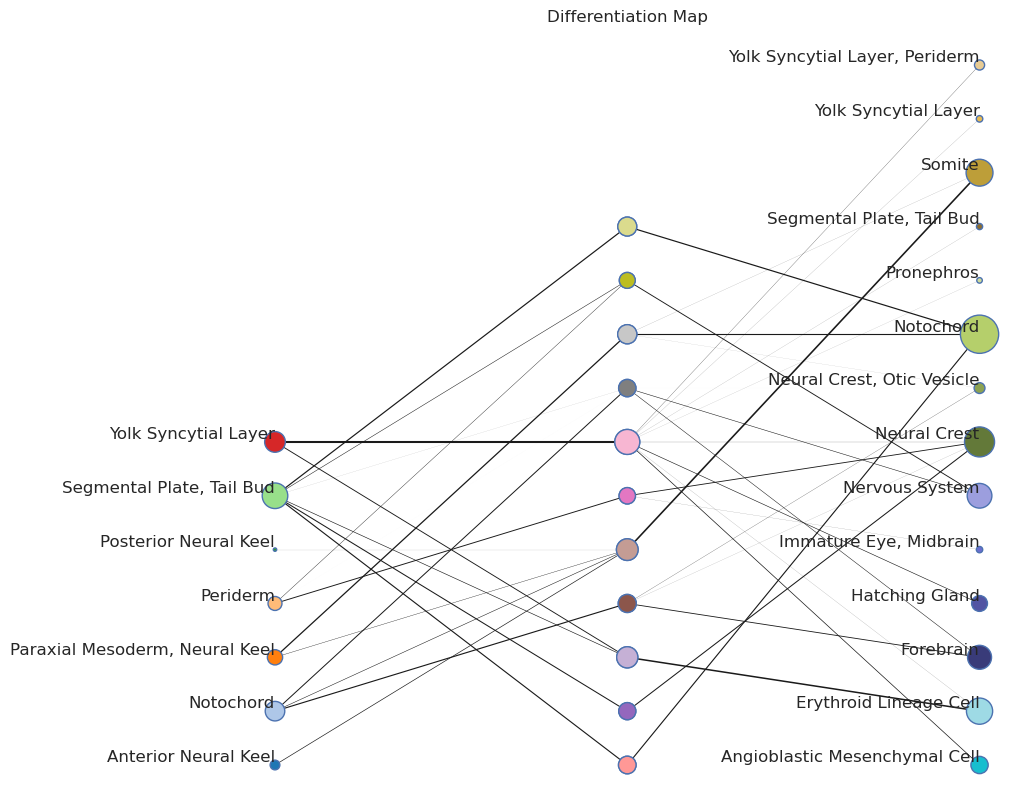

In [28]:
importlib.reload(clustering)

ct_ann_0 = labels[i]
ct_ann_1 = labels[i+1]
ct_ann_2 = labels[i+2]

Qs_ann = [Q0.cpu().numpy(), Q1.cpu().numpy(), Q2.cpu().numpy()]
Ts_ann = [T_tm1t.cpu().numpy(), T_ttp1.cpu().numpy()]
node_labels1 = [ct_ann_0, None, ct_ann_2]

clustering.diffmap_from_QT(Qs_ann, Ts_ann, node_labels=node_labels1)

/tmp/ipykernel_2627051/1887215375.py:6: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  _adata1.obs['diff_map_cluster'] = cell_type_labelsA


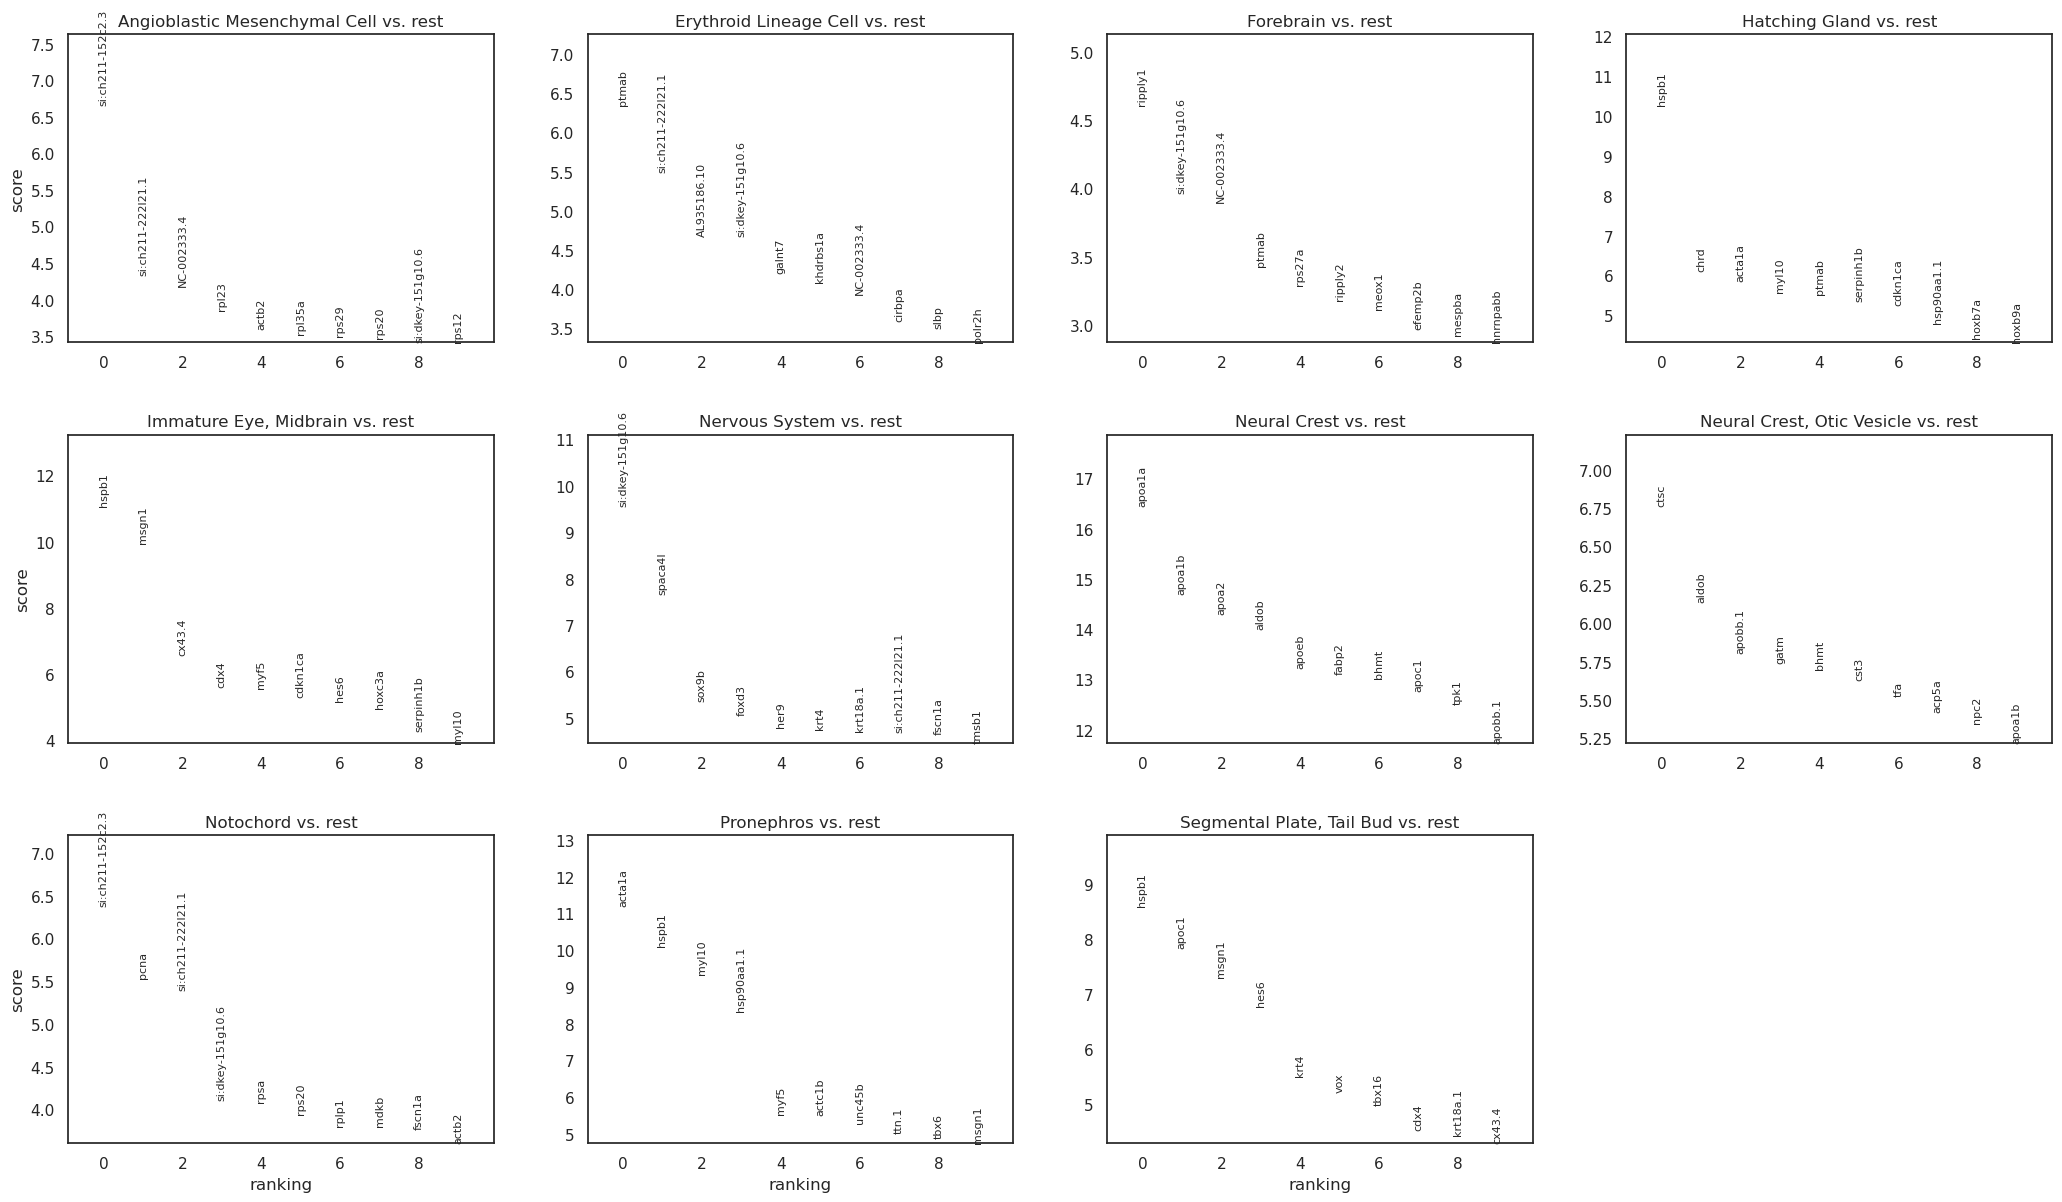

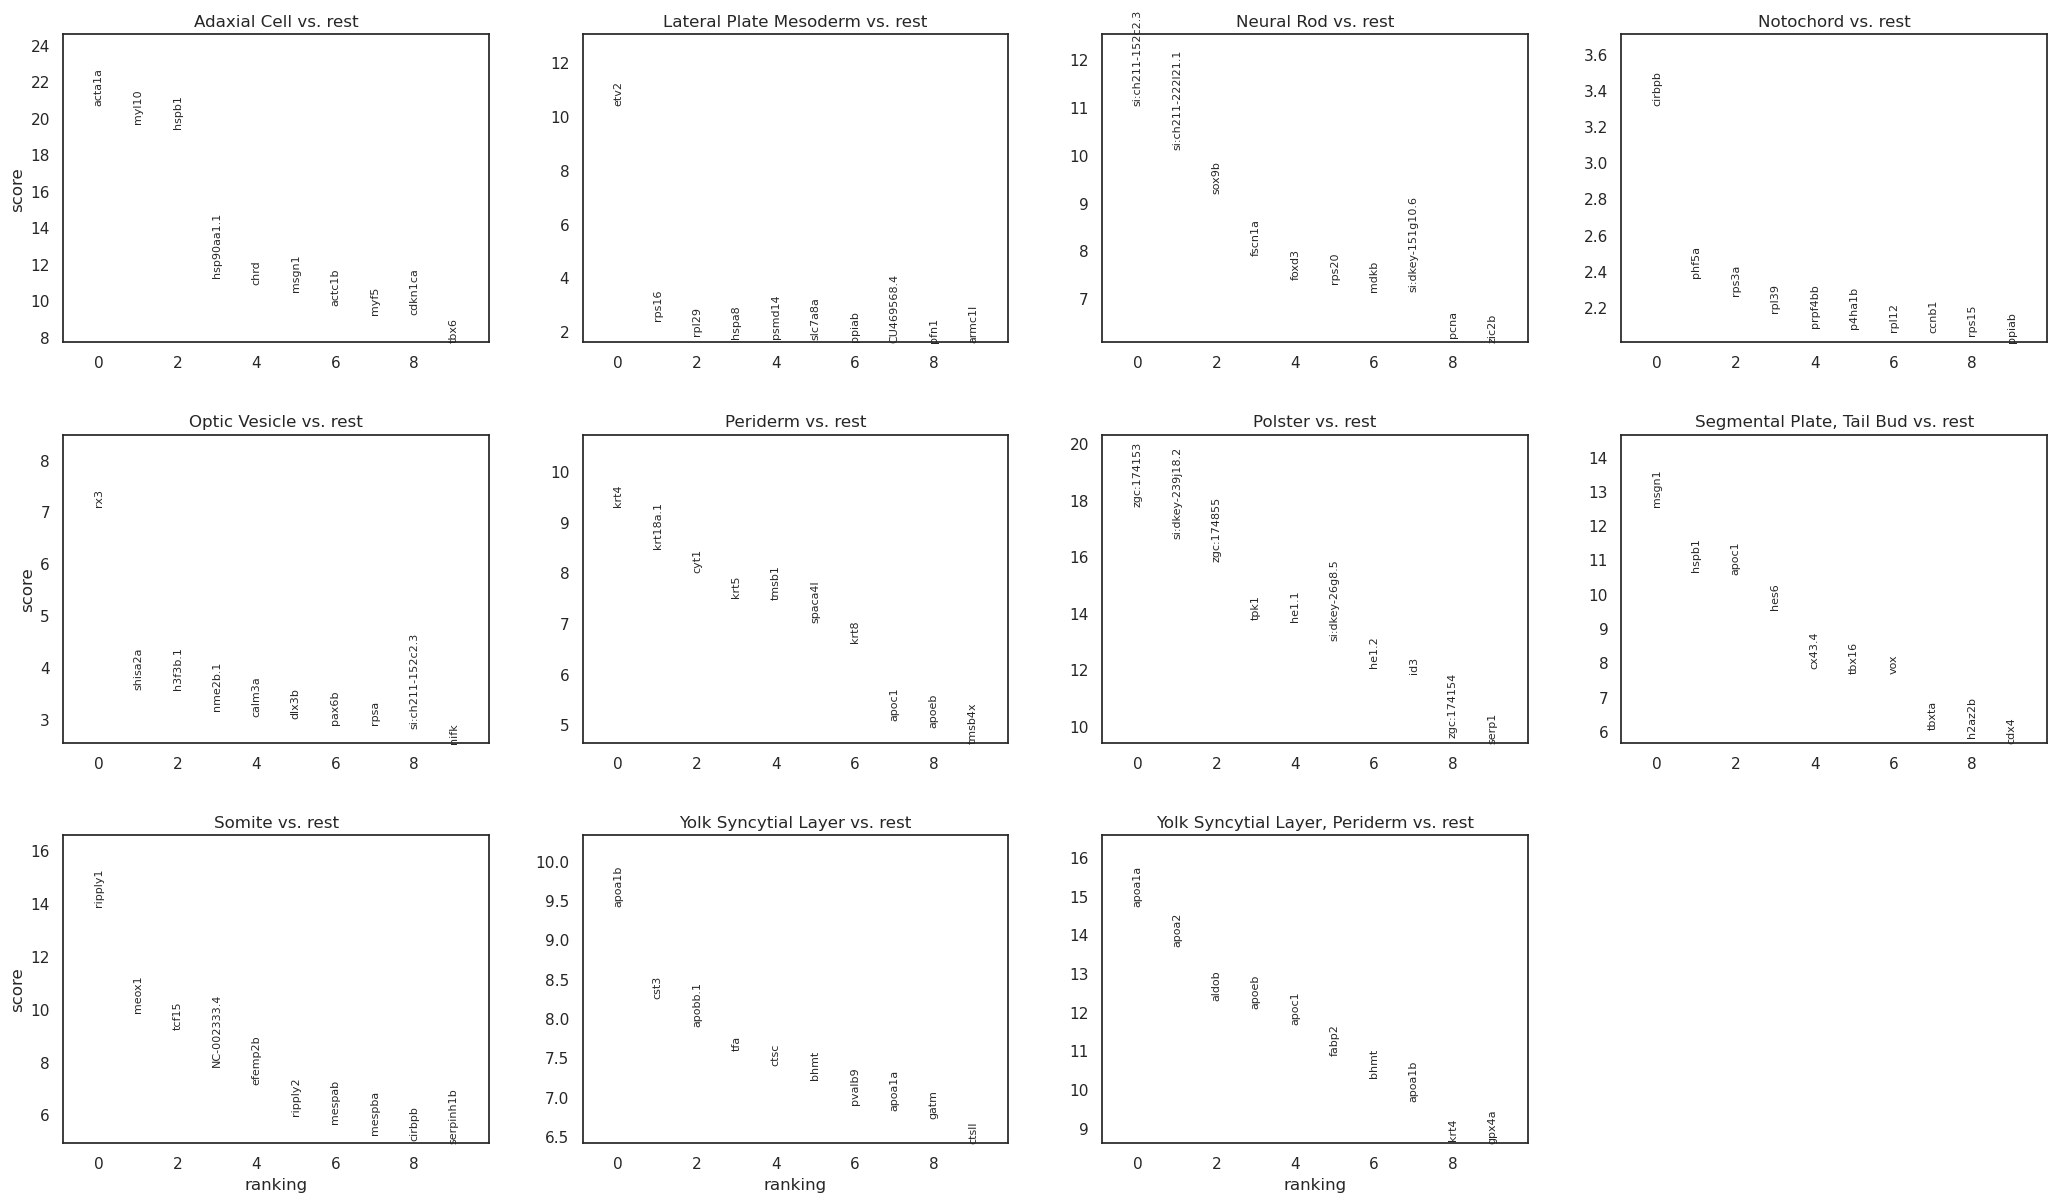

In [18]:
if nidx_2 is not None:
    _adata1 = adata1[adata1.obs.index != adata1.obs.index[nidx_2], :]
if nidx_3 is not None:
    _adata2 = adata2[adata2.obs.index != adata2.obs.index[nidx_3], :]

_adata1.obs['diff_map_cluster'] = cell_type_labelsA
_adata1.obs['diff_map_cluster'] = _adata1.obs['diff_map_cluster'].astype('category')
sc.pp.normalize_total(_adata1)
#sc.pp.log1p(_adata1)

'''
_adata2.obs['diff_map_cluster'] = cell_type_labelsB
_adata2.obs['diff_map_cluster'] = _adata2.obs['diff_map_cluster'].astype('category')
sc.pp.normalize_total(adata2)
sc.pp.log1p(adata2)
'''

# Differential gene expression analysis
sc.tl.rank_genes_groups(_adata1, groupby='diff_map_cluster', method='t-test', key_added = "t-test")
sc.pl.rank_genes_groups(_adata1, n_genes=10, sharey=False, key = "t-test")

# Bin-annotation
sc.tl.rank_genes_groups(_adata1, groupby='bin_annotation', method='t-test', key_added = "t-test")
sc.pl.rank_genes_groups(_adata1, n_genes=10, sharey=False, key = "t-test")